<a href="https://colab.research.google.com/github/bjih1999/cifar_img_classify_project/blob/master/plz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import**

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import cifar10
from keras.utils import np_utils
from sklearn.manifold import TSNE
from PIL import Image

In [10]:
input_shape = (32, 32, 3)
num_classes = 10
epochs = 10
batch_size = 512

In [6]:
def show_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
 
    loss=history.history['loss']
    val_loss=history.history['val_loss']
 
    epochs_range = range(len(history.history['accuracy']))
    # epochs_range = range(epochs*5)
 
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
 
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [7]:
def load_image_and_label_regularated():
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    train_images = train_images.reshape((50000, 32, 32, 3))
    test_images = test_images.reshape((10000, 32, 32, 3))
    train_images, test_images = train_images / 255.0, test_images / 255.0
    return (train_images, train_labels), (test_images, test_labels)

**get CAM**

In [8]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


**save CAM**

In [9]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.05):
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    return superimposed_img

**get t-sne**

In [121]:
def get_tsne(model, layer_name, x_data, y_data, height, width, channel, size=100, batch_size=512):
  feat_extractor = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
  features = feat_extractor.predict(x_data[:size], batch_size=batch_size)
  features = features.reshape(size,height*width*channel)

  tsne = TSNE().fit_transform(features)
  tx, ty = tsne[:,0], tsne[:,1]
  tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
  ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

  y_data = y_data[:size]
  colors = cm.rainbow(np.linspace(0, 1, ))

  for i in range(10):
    x_data = np.where(np.where(y_data==1)[1] == i)
    plt.scatter(tx[x_data], ty[x_data], marker='.') 
  plt.show()



In [ ]:
feat_extractor = tf.keras.models.Model(inputs=model16.input, outputs=model16.get_layer('conv2d').output)
features = feat_extractor.predict(x_test[:100], batch_size=batch_size)
features.shape

(100, 32, 32, 128)

In [ ]:
features = features.reshape(100,32*32*128)
features.shape

(100, 131072)

In [ ]:
tsne = TSNE().fit_transform(features)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

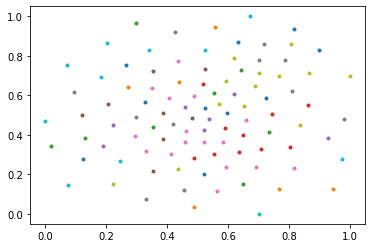

In [ ]:
y_test = y_test[:100]
colors = cm.rainbow(np.linspace(0, 1, ))

for i in range(10):
  x_index = np.where(np.where(y_test==1)[1] == i)
  plt.scatter(tx[x_index], ty[x_index], marker='.') 

plt.show()

**cifar 10 raw data**

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
 
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [ ]:
model = keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result1 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.summary()

Epoch 1/10
98/98 [==============================] - 1s 10ms/step - loss: 6.2940 - accuracy: 0.2857 - val_loss: 1.5818 - val_accuracy: 0.4385
Epoch 2/10
98/98 [==============================] - 1s 8ms/step - loss: 1.4854 - accuracy: 0.4725 - val_loss: 1.4253 - val_accuracy: 0.4976
Epoch 3/10
98/98 [==============================] - 1s 8ms/step - loss: 1.3156 - accuracy: 0.5330 - val_loss: 1.3053 - val_accuracy: 0.5425
Epoch 4/10
98/98 [==============================] - 1s 8ms/step - loss: 1.1900 - accuracy: 0.5797 - val_loss: 1.2532 - val_accuracy: 0.5654
Epoch 5/10
98/98 [==============================] - 1s 8ms/step - loss: 1.0784 - accuracy: 0.6206 - val_loss: 1.2217 - val_accuracy: 0.5737
Epoch 6/10
98/98 [==============================] - 1s 8ms/step - loss: 0.9879 - accuracy: 0.6525 - val_loss: 1.2134 - val_accuracy: 0.5816
Epoch 7/10
98/98 [==============================] - 1s 8ms/step - loss: 0.9099 - accuracy: 0.6808 - val_loss: 1.2314 - val_accuracy: 0.5830
Epoch 8/10
98/98 [=

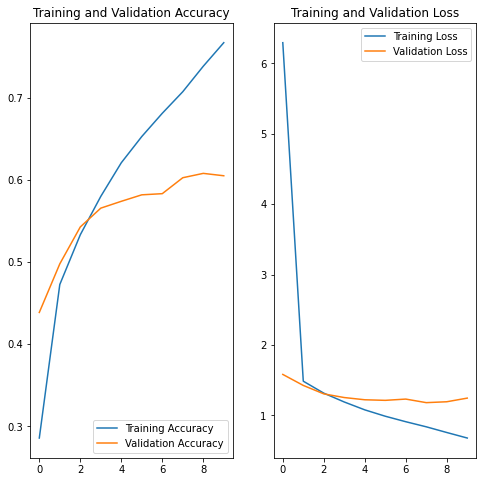

In [ ]:
show_accuracy(result1)

**cifar 10 divided by 255**

In [ ]:
(x_train, y_train), (x_test, y_test) = load_image_and_label_regularated()

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)



In [ ]:
model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result2 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.summary()

Epoch 1/10
98/98 [==============================] - 2s 12ms/step - loss: 1.7744 - accuracy: 0.3648 - val_loss: 1.5251 - val_accuracy: 0.4587
Epoch 2/10
98/98 [==============================] - 1s 10ms/step - loss: 1.4293 - accuracy: 0.4915 - val_loss: 1.3957 - val_accuracy: 0.5066
Epoch 3/10
98/98 [==============================] - 1s 10ms/step - loss: 1.2924 - accuracy: 0.5437 - val_loss: 1.2378 - val_accuracy: 0.5654
Epoch 4/10
98/98 [==============================] - 1s 10ms/step - loss: 1.1882 - accuracy: 0.5823 - val_loss: 1.1539 - val_accuracy: 0.5942
Epoch 5/10
98/98 [==============================] - 1s 10ms/step - loss: 1.1120 - accuracy: 0.6084 - val_loss: 1.1079 - val_accuracy: 0.6100
Epoch 6/10
98/98 [==============================] - 1s 10ms/step - loss: 1.0494 - accuracy: 0.6313 - val_loss: 1.0444 - val_accuracy: 0.6327
Epoch 7/10
98/98 [==============================] - 1s 10ms/step - loss: 0.9900 - accuracy: 0.6519 - val_loss: 1.0292 - val_accuracy: 0.6345
Epoch 8/10
98

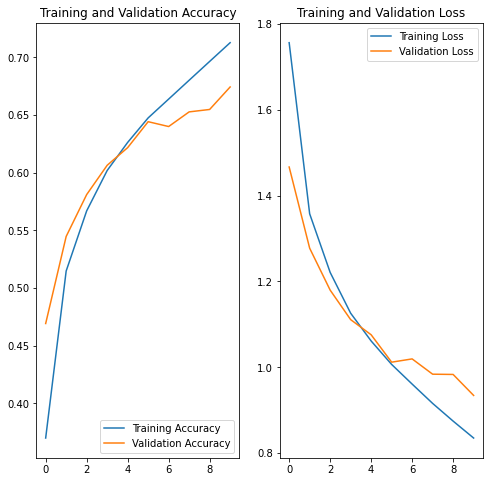

In [ ]:
show_accuracy(result2)

**cifar 10 regularated**


In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
 
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

mean=[0,0,0]
std=[0,0,0]
newX_train = np.ones(x_train.shape)
newX_test = np.ones(x_test.shape)
 
for i in range(3):
    mean[i] = np.mean(x_train[:,:,:,i])
    std[i] = np.std(x_train[:,:,:,i])
 
for i in range(3):
    newX_train[:,:,:,i] = x_train[:,:,:,i] - mean[i]
    newX_train[:,:,:,i] = newX_train[:,:,:,i] / std[i]
    newX_test[:,:,:,i] = x_test[:,:,:,i] - mean[i]
    newX_test[:,:,:,i] = newX_test[:,:,:,i] / std[i]
        
x_train = newX_train
x_test = newX_test

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result3 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.summary()

Epoch 1/10
98/98 [==============================] - 2s 15ms/step - loss: 1.6047 - accuracy: 0.4290 - val_loss: 1.3565 - val_accuracy: 0.5231
Epoch 2/10
98/98 [==============================] - 1s 11ms/step - loss: 1.2265 - accuracy: 0.5654 - val_loss: 1.1515 - val_accuracy: 0.5933
Epoch 3/10
98/98 [==============================] - 1s 10ms/step - loss: 1.0743 - accuracy: 0.6224 - val_loss: 1.0832 - val_accuracy: 0.6177
Epoch 4/10
98/98 [==============================] - 1s 10ms/step - loss: 0.9724 - accuracy: 0.6610 - val_loss: 1.0337 - val_accuracy: 0.6341
Epoch 5/10
98/98 [==============================] - 1s 10ms/step - loss: 0.8892 - accuracy: 0.6903 - val_loss: 0.9372 - val_accuracy: 0.6757
Epoch 6/10
98/98 [==============================] - 1s 10ms/step - loss: 0.8196 - accuracy: 0.7163 - val_loss: 0.9396 - val_accuracy: 0.6755
Epoch 7/10
98/98 [==============================] - 1s 10ms/step - loss: 0.7596 - accuracy: 0.7359 - val_loss: 0.8871 - val_accuracy: 0.6924
Epoch 8/10
98

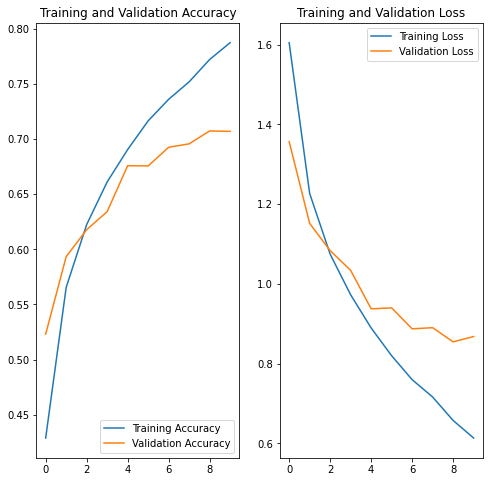

In [ ]:
show_accuracy(result3)

**필터 개수 점점 줄이기**

In [ ]:
model = keras.Sequential([
    layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result5 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.summary()

Epoch 1/10
98/98 [==============================] - 2s 15ms/step - loss: 1.6216 - accuracy: 0.4158 - val_loss: 1.3552 - val_accuracy: 0.5214
Epoch 2/10
98/98 [==============================] - 1s 13ms/step - loss: 1.2700 - accuracy: 0.5487 - val_loss: 1.2159 - val_accuracy: 0.5606
Epoch 3/10
98/98 [==============================] - 1s 13ms/step - loss: 1.1321 - accuracy: 0.5993 - val_loss: 1.1008 - val_accuracy: 0.6078
Epoch 4/10
98/98 [==============================] - 1s 14ms/step - loss: 1.0413 - accuracy: 0.6330 - val_loss: 1.0596 - val_accuracy: 0.6232
Epoch 5/10
98/98 [==============================] - 1s 13ms/step - loss: 0.9718 - accuracy: 0.6587 - val_loss: 0.9986 - val_accuracy: 0.6430
Epoch 6/10
98/98 [==============================] - 1s 13ms/step - loss: 0.9131 - accuracy: 0.6809 - val_loss: 1.0065 - val_accuracy: 0.6439
Epoch 7/10
98/98 [==============================] - 1s 13ms/step - loss: 0.8662 - accuracy: 0.6963 - val_loss: 0.9150 - val_accuracy: 0.6761
Epoch 8/10
98

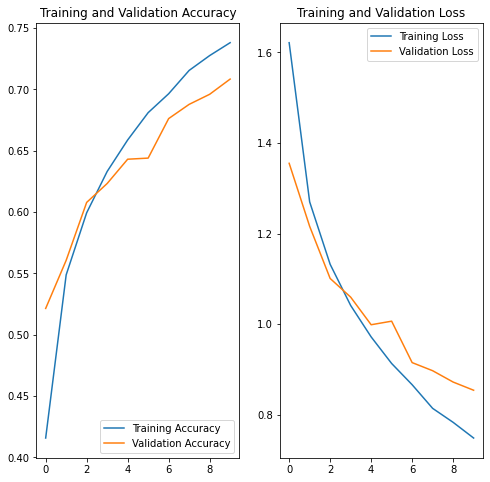

In [ ]:
show_accuracy(result5)

**레이어 추가**

In [ ]:
model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result6 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.summary()

Epoch 1/10
98/98 [==============================] - 2s 19ms/step - loss: 1.6976 - accuracy: 0.3835 - val_loss: 1.3979 - val_accuracy: 0.4912
Epoch 2/10
98/98 [==============================] - 2s 17ms/step - loss: 1.2930 - accuracy: 0.5377 - val_loss: 1.1944 - val_accuracy: 0.5729
Epoch 3/10
98/98 [==============================] - 2s 16ms/step - loss: 1.1120 - accuracy: 0.6061 - val_loss: 1.0728 - val_accuracy: 0.6169
Epoch 4/10
98/98 [==============================] - 2s 16ms/step - loss: 0.9852 - accuracy: 0.6511 - val_loss: 0.9927 - val_accuracy: 0.6457
Epoch 5/10
98/98 [==============================] - 2s 17ms/step - loss: 0.9017 - accuracy: 0.6833 - val_loss: 0.9317 - val_accuracy: 0.6752
Epoch 6/10
98/98 [==============================] - 2s 16ms/step - loss: 0.8134 - accuracy: 0.7159 - val_loss: 0.8980 - val_accuracy: 0.6885
Epoch 7/10
98/98 [==============================] - 2s 16ms/step - loss: 0.7388 - accuracy: 0.7431 - val_loss: 0.8594 - val_accuracy: 0.7026
Epoch 8/10
98

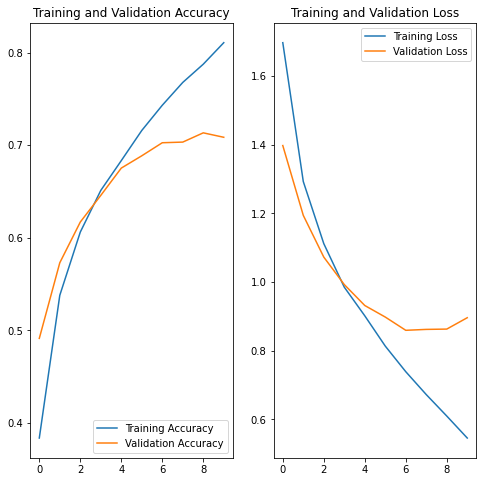

In [ ]:
show_accuracy(result6)

**레이어 더 추가**

In [ ]:
model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result7 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.summary()

Epoch 1/10
98/98 [==============================] - 3s 25ms/step - loss: 1.7921 - accuracy: 0.3388 - val_loss: 1.4933 - val_accuracy: 0.4528
Epoch 2/10
98/98 [==============================] - 2s 22ms/step - loss: 1.3774 - accuracy: 0.4974 - val_loss: 1.2874 - val_accuracy: 0.5325
Epoch 3/10
98/98 [==============================] - 2s 22ms/step - loss: 1.1918 - accuracy: 0.5701 - val_loss: 1.1306 - val_accuracy: 0.5896
Epoch 4/10
98/98 [==============================] - 2s 22ms/step - loss: 1.0681 - accuracy: 0.6173 - val_loss: 1.0401 - val_accuracy: 0.6251
Epoch 5/10
98/98 [==============================] - 2s 22ms/step - loss: 0.9651 - accuracy: 0.6559 - val_loss: 0.9767 - val_accuracy: 0.6528
Epoch 6/10
98/98 [==============================] - 2s 22ms/step - loss: 0.8763 - accuracy: 0.6900 - val_loss: 0.9590 - val_accuracy: 0.6636
Epoch 7/10
98/98 [==============================] - 2s 22ms/step - loss: 0.8002 - accuracy: 0.7179 - val_loss: 0.8915 - val_accuracy: 0.6832
Epoch 8/10
98

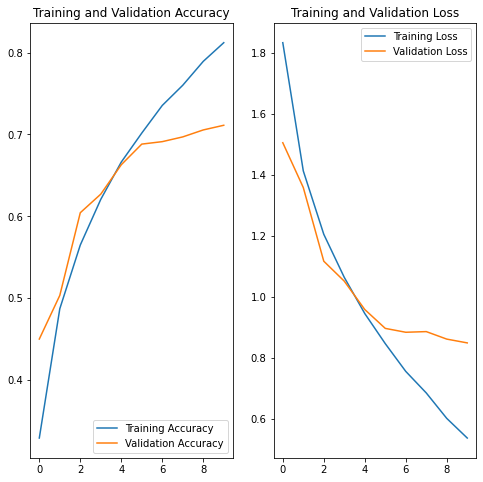

In [ ]:
show_accuracy(result7)

**#8 epoch 20**

In [ ]:
epochs = 20

In [ ]:
model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result8 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.summary()

Epoch 1/20
98/98 [==============================] - 3s 24ms/step - loss: 1.8013 - accuracy: 0.3458 - val_loss: 1.4441 - val_accuracy: 0.4730
Epoch 2/20
98/98 [==============================] - 2s 22ms/step - loss: 1.3555 - accuracy: 0.5134 - val_loss: 1.2473 - val_accuracy: 0.5517
Epoch 3/20
98/98 [==============================] - 2s 22ms/step - loss: 1.1723 - accuracy: 0.5836 - val_loss: 1.1327 - val_accuracy: 0.5908
Epoch 4/20
98/98 [==============================] - 2s 22ms/step - loss: 1.0226 - accuracy: 0.6372 - val_loss: 1.0054 - val_accuracy: 0.6438
Epoch 5/20
98/98 [==============================] - 2s 22ms/step - loss: 0.9306 - accuracy: 0.6719 - val_loss: 0.9749 - val_accuracy: 0.6567
Epoch 6/20
98/98 [==============================] - 2s 22ms/step - loss: 0.8228 - accuracy: 0.7121 - val_loss: 0.9159 - val_accuracy: 0.6741
Epoch 7/20
98/98 [==============================] - 2s 22ms/step - loss: 0.7427 - accuracy: 0.7396 - val_loss: 0.8973 - val_accuracy: 0.6910
Epoch 8/20
98

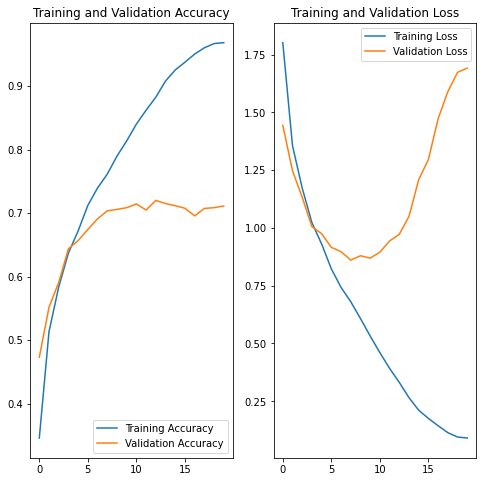

In [ ]:
show_accuracy(result8)

**#9 drop out 0.5**

In [ ]:
dropout = 0.5

In [ ]:
model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result9 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.summary()

Epoch 1/20
98/98 [==============================] - 3s 25ms/step - loss: 1.8341 - accuracy: 0.3224 - val_loss: 1.5293 - val_accuracy: 0.4303
Epoch 2/20
98/98 [==============================] - 2s 22ms/step - loss: 1.4676 - accuracy: 0.4622 - val_loss: 1.3102 - val_accuracy: 0.5196
Epoch 3/20
98/98 [==============================] - 2s 22ms/step - loss: 1.3112 - accuracy: 0.5238 - val_loss: 1.1887 - val_accuracy: 0.5712
Epoch 4/20
98/98 [==============================] - 2s 22ms/step - loss: 1.1999 - accuracy: 0.5665 - val_loss: 1.1313 - val_accuracy: 0.5987
Epoch 5/20
98/98 [==============================] - 2s 22ms/step - loss: 1.1056 - accuracy: 0.6061 - val_loss: 1.0335 - val_accuracy: 0.6313
Epoch 6/20
98/98 [==============================] - 2s 22ms/step - loss: 1.0301 - accuracy: 0.6324 - val_loss: 0.9995 - val_accuracy: 0.6468
Epoch 7/20
98/98 [==============================] - 2s 22ms/step - loss: 0.9641 - accuracy: 0.6589 - val_loss: 0.9606 - val_accuracy: 0.6621
Epoch 8/20
98

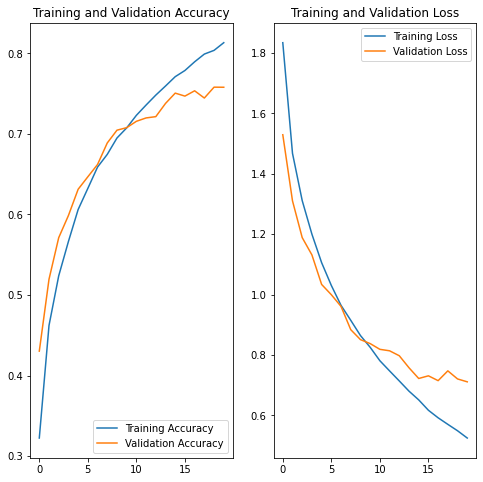

In [ ]:
show_accuracy(result9)

**#10 add drop out**

In [ ]:
 model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result10 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.summary()

Epoch 1/20
98/98 [==============================] - 4s 39ms/step - loss: 1.9279 - accuracy: 0.2846 - val_loss: 1.7280 - val_accuracy: 0.3581
Epoch 2/20
98/98 [==============================] - 4s 36ms/step - loss: 1.5570 - accuracy: 0.4198 - val_loss: 1.5107 - val_accuracy: 0.4487
Epoch 3/20
98/98 [==============================] - 4s 37ms/step - loss: 1.4147 - accuracy: 0.4809 - val_loss: 1.2963 - val_accuracy: 0.5279
Epoch 4/20
98/98 [==============================] - 4s 37ms/step - loss: 1.3192 - accuracy: 0.5201 - val_loss: 1.2452 - val_accuracy: 0.5452
Epoch 5/20
98/98 [==============================] - 4s 37ms/step - loss: 1.2375 - accuracy: 0.5502 - val_loss: 1.1938 - val_accuracy: 0.5736
Epoch 6/20
98/98 [==============================] - 4s 37ms/step - loss: 1.1696 - accuracy: 0.5769 - val_loss: 1.1613 - val_accuracy: 0.5914
Epoch 7/20
98/98 [==============================] - 4s 37ms/step - loss: 1.1196 - accuracy: 0.5973 - val_loss: 1.1089 - val_accuracy: 0.6118
Epoch 8/20
98

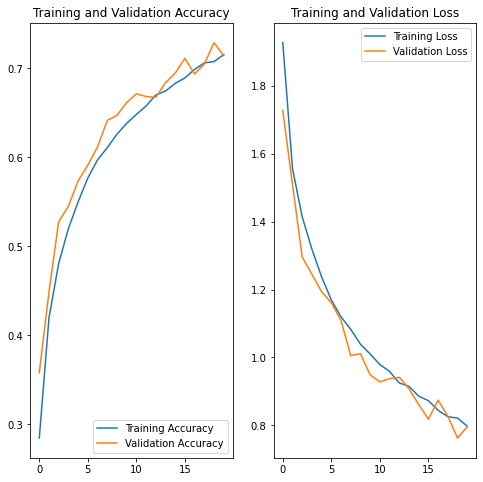

In [ ]:
show_accuracy(result10)

**drop out 2개**

In [ ]:
 model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result11 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)
model.summary()

Epoch 1/20
98/98 [==============================] - 5s 40ms/step - loss: 1.9405 - accuracy: 0.2808 - val_loss: 1.6620 - val_accuracy: 0.3894
Epoch 2/20
98/98 [==============================] - 4s 37ms/step - loss: 1.5486 - accuracy: 0.4262 - val_loss: 1.4232 - val_accuracy: 0.4750
Epoch 3/20
98/98 [==============================] - 4s 37ms/step - loss: 1.3637 - accuracy: 0.5013 - val_loss: 1.1965 - val_accuracy: 0.5600
Epoch 4/20
98/98 [==============================] - 4s 38ms/step - loss: 1.2382 - accuracy: 0.5485 - val_loss: 1.1528 - val_accuracy: 0.5805
Epoch 5/20
98/98 [==============================] - 4s 37ms/step - loss: 1.1518 - accuracy: 0.5822 - val_loss: 1.0882 - val_accuracy: 0.6132
Epoch 6/20
98/98 [==============================] - 4s 38ms/step - loss: 1.0876 - accuracy: 0.6080 - val_loss: 1.0161 - val_accuracy: 0.6340
Epoch 7/20
98/98 [==============================] - 4s 38ms/step - loss: 1.0327 - accuracy: 0.6300 - val_loss: 0.9838 - val_accuracy: 0.6544
Epoch 8/20
98

In [ ]:
show_accurarcy(result11)

**#12 epochs 100**

In [ ]:
epochs=100

In [ ]:
 dropout = 0.5
 epochs = 100
 
 model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result12 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model.summary()

Epoch 1/100
98/98 [==============================] - 5s 42ms/step - loss: 1.8825 - accuracy: 0.3020 - val_loss: 1.5567 - val_accuracy: 0.4255
Epoch 2/100
98/98 [==============================] - 4s 37ms/step - loss: 1.5261 - accuracy: 0.4368 - val_loss: 1.3847 - val_accuracy: 0.4923
Epoch 3/100
98/98 [==============================] - 4s 37ms/step - loss: 1.3777 - accuracy: 0.4952 - val_loss: 1.3030 - val_accuracy: 0.5225
Epoch 4/100
98/98 [==============================] - 4s 37ms/step - loss: 1.2977 - accuracy: 0.5277 - val_loss: 1.1853 - val_accuracy: 0.5714
Epoch 5/100
98/98 [==============================] - 4s 37ms/step - loss: 1.2063 - accuracy: 0.5617 - val_loss: 1.1282 - val_accuracy: 0.5910
Epoch 6/100
98/98 [==============================] - 4s 37ms/step - loss: 1.1586 - accuracy: 0.5783 - val_loss: 1.0613 - val_accuracy: 0.6241
Epoch 7/100
98/98 [==============================] - 4s 37ms/step - loss: 1.0909 - accuracy: 0.6070 - val_loss: 1.0091 - val_accuracy: 0.6395
Epoch 

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.6131 - accuracy: 0.7982
0.6131131052970886
0.7982000112533569


(None, None)

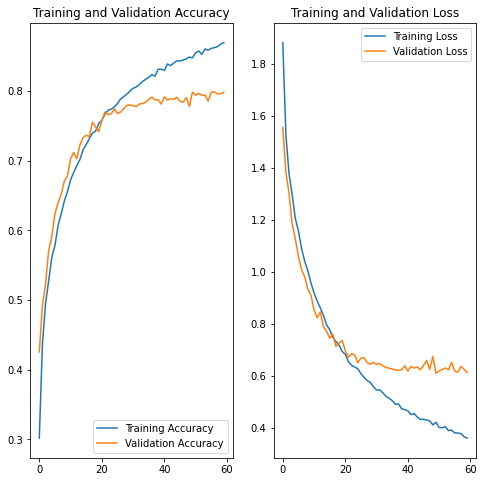

In [ ]:
show_accuracy(result12)

**#13 dropout 3개 & epochs 100**

In [ ]:
 dropout = 0.5
 epochs = 100
 
 model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result13 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model.summary()

Epoch 1/100
98/98 [==============================] - 36s 45ms/step - loss: 1.8904 - accuracy: 0.2915 - val_loss: 1.6804 - val_accuracy: 0.3787
Epoch 2/100
98/98 [==============================] - 4s 37ms/step - loss: 1.5729 - accuracy: 0.4123 - val_loss: 1.4365 - val_accuracy: 0.4721
Epoch 3/100
98/98 [==============================] - 4s 37ms/step - loss: 1.4382 - accuracy: 0.4638 - val_loss: 1.5610 - val_accuracy: 0.4427
Epoch 4/100
98/98 [==============================] - 4s 37ms/step - loss: 1.3529 - accuracy: 0.5025 - val_loss: 1.2871 - val_accuracy: 0.5403
Epoch 5/100
98/98 [==============================] - 4s 37ms/step - loss: 1.2812 - accuracy: 0.5323 - val_loss: 1.2232 - val_accuracy: 0.5565
Epoch 6/100
98/98 [==============================] - 4s 38ms/step - loss: 1.2096 - accuracy: 0.5609 - val_loss: 1.1245 - val_accuracy: 0.5986
Epoch 7/100
98/98 [==============================] - 4s 38ms/step - loss: 1.1607 - accuracy: 0.5810 - val_loss: 1.2220 - val_accuracy: 0.5669
Epoch

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.6493 - accuracy: 0.7837
0.6493158936500549
0.7836999893188477


(None, None)

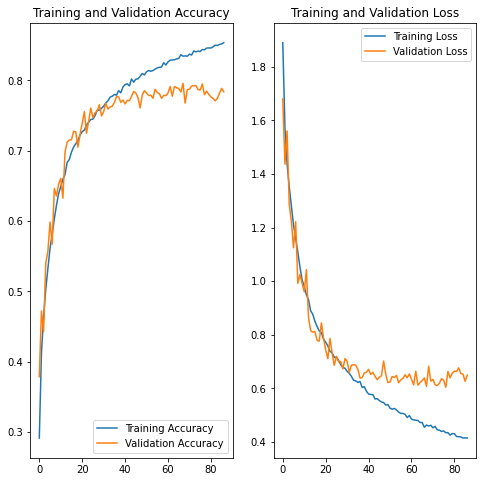

In [ ]:
show_accuracy(result13)

**#14 add 128 kernel layers**

In [ ]:
dropout = 0.5
epochs = 100

model = keras.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result14 = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model.summary()

Epoch 1/100
98/98 [==============================] - 6s 48ms/step - loss: 2.0527 - accuracy: 0.2122 - val_loss: 1.8274 - val_accuracy: 0.2804
Epoch 2/100
98/98 [==============================] - 4s 42ms/step - loss: 1.6458 - accuracy: 0.3679 - val_loss: 1.4875 - val_accuracy: 0.4457
Epoch 3/100
98/98 [==============================] - 4s 41ms/step - loss: 1.4562 - accuracy: 0.4583 - val_loss: 1.3487 - val_accuracy: 0.5061
Epoch 4/100
98/98 [==============================] - 4s 41ms/step - loss: 1.3472 - accuracy: 0.5077 - val_loss: 1.2443 - val_accuracy: 0.5427
Epoch 5/100
98/98 [==============================] - 4s 41ms/step - loss: 1.2698 - accuracy: 0.5360 - val_loss: 1.1634 - val_accuracy: 0.5774
Epoch 6/100
98/98 [==============================] - 4s 41ms/step - loss: 1.2133 - accuracy: 0.5604 - val_loss: 1.1698 - val_accuracy: 0.5827
Epoch 7/100
98/98 [==============================] - 4s 41ms/step - loss: 1.1455 - accuracy: 0.5884 - val_loss: 1.0922 - val_accuracy: 0.6045
Epoch 

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.6401 - accuracy: 0.7884
0.6401111483573914
0.7883999943733215


(None, None)

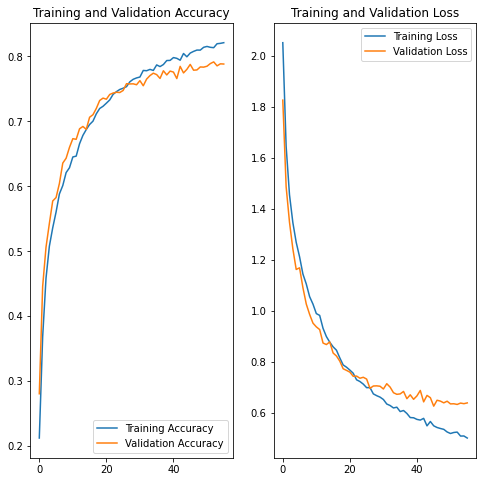

In [ ]:
show_accuracy(result14)

**#15 reduce layer and increase kernel**

In [ ]:
dropout = 0.5
epochs = 100

model15 = keras.Sequential([
    
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model15.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result15 = model15.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model15.summary()

Epoch 1/100
98/98 [==============================] - 6s 51ms/step - loss: 2.0378 - accuracy: 0.3612 - val_loss: 1.5584 - val_accuracy: 0.5060
Epoch 2/100
98/98 [==============================] - 5s 48ms/step - loss: 1.4518 - accuracy: 0.5485 - val_loss: 1.2696 - val_accuracy: 0.6154
Epoch 3/100
98/98 [==============================] - 5s 49ms/step - loss: 1.2516 - accuracy: 0.6290 - val_loss: 1.2270 - val_accuracy: 0.6476
Epoch 4/100
98/98 [==============================] - 5s 48ms/step - loss: 1.1467 - accuracy: 0.6750 - val_loss: 1.0687 - val_accuracy: 0.7071
Epoch 5/100
98/98 [==============================] - 5s 49ms/step - loss: 1.0670 - accuracy: 0.7091 - val_loss: 1.0187 - val_accuracy: 0.7319
Epoch 6/100
98/98 [==============================] - 5s 48ms/step - loss: 1.0210 - accuracy: 0.7276 - val_loss: 0.9631 - val_accuracy: 0.7577
Epoch 7/100
98/98 [==============================] - 5s 49ms/step - loss: 0.9792 - accuracy: 0.7474 - val_loss: 0.9472 - val_accuracy: 0.7661
Epoch 

In [ ]:
test_loss, test_acc = model15.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 1s - loss: 0.8372 - accuracy: 0.8282
0.8372262716293335
0.8281999826431274


(None, None)

**#16 increase kernel**

In [12]:
dropout = 0.5
epochs = 100

model16 = keras.Sequential([
    
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=input_shape),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Conv2D(1024, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result16 = model16.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model16.summary()

Epoch 1/100
98/98 [==============================] - 52s 162ms/step - loss: 2.3364 - accuracy: 0.3215 - val_loss: 1.6587 - val_accuracy: 0.4857
Epoch 2/100
98/98 [==============================] - 11s 112ms/step - loss: 1.5280 - accuracy: 0.5109 - val_loss: 1.3790 - val_accuracy: 0.5629
Epoch 3/100
98/98 [==============================] - 11s 113ms/step - loss: 1.2847 - accuracy: 0.5981 - val_loss: 1.1550 - val_accuracy: 0.6529
Epoch 4/100
98/98 [==============================] - 11s 115ms/step - loss: 1.1387 - accuracy: 0.6571 - val_loss: 1.0464 - val_accuracy: 0.7092
Epoch 5/100
98/98 [==============================] - 11s 117ms/step - loss: 1.0500 - accuracy: 0.6946 - val_loss: 0.9889 - val_accuracy: 0.7278
Epoch 6/100
98/98 [==============================] - 12s 119ms/step - loss: 0.9982 - accuracy: 0.7158 - val_loss: 0.9203 - val_accuracy: 0.7496
Epoch 7/100
98/98 [==============================] - 12s 118ms/step - loss: 0.9603 - accuracy: 0.7340 - val_loss: 0.9386 - val_accuracy:

In [13]:
test_loss, test_acc = model16.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 2s - loss: 0.8144 - accuracy: 0.8257
0.8144329190254211
0.8256999850273132


(None, None)

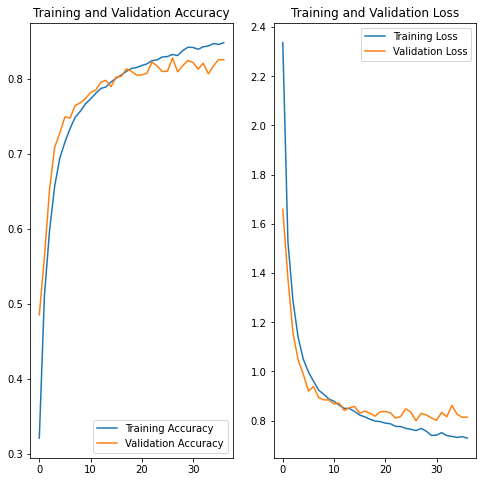

In [14]:
show_accuracy(result16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label :  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


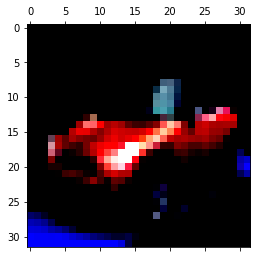

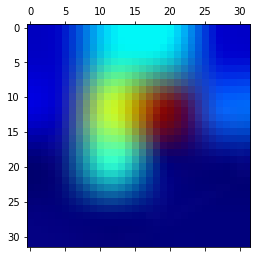

In [58]:
last_conv_layer_name = 'conv2d_3'
index = 6555
img = x_test[index]
plt.matshow(img)
img = img.reshape(-1, 32, 32, 3)
src_img = img.reshape(32, 32, 3)
heatmap = make_gradcam_heatmap(img, model16, last_conv_layer_name)
CAM = save_and_display_gradcam(src_img, heatmap, alpha=0.4)
plt.matshow(CAM)
print('label : ', y_test[index])

**t-sne (2번째 인자 레이어로 바꿔주면 다른 레이어 볼 수 있음)**

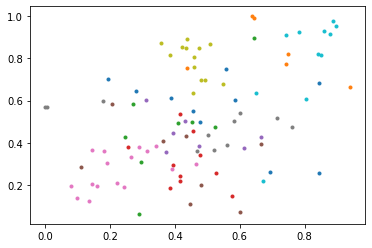

In [126]:
get_tsne(model16, 'conv2d_3', x_test, y_test, 4, 4, 1024, size=300)

**#17 increase kernel**

In [ ]:
dropout = 0.5
epochs = 100

model17 = keras.Sequential([
    
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Conv2D(1024, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.Conv2D(2048, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.Flatten(),
    layers.Dense(2048, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model17.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result17 = model17.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model17.summary()

Epoch 1/100
98/98 [==============================] - 68s 282ms/step - loss: 3.1114 - accuracy: 0.1533 - val_loss: 2.3021 - val_accuracy: 0.2297
Epoch 2/100
98/98 [==============================] - 18s 189ms/step - loss: 2.0268 - accuracy: 0.2977 - val_loss: 1.7288 - val_accuracy: 0.3936
Epoch 3/100
98/98 [==============================] - 19s 191ms/step - loss: 1.6531 - accuracy: 0.4283 - val_loss: 1.4999 - val_accuracy: 0.4905
Epoch 4/100
98/98 [==============================] - 19s 192ms/step - loss: 1.4506 - accuracy: 0.5095 - val_loss: 1.2966 - val_accuracy: 0.5738
Epoch 5/100
98/98 [==============================] - 19s 193ms/step - loss: 1.3381 - accuracy: 0.5551 - val_loss: 1.2127 - val_accuracy: 0.6037
Epoch 6/100
98/98 [==============================] - 19s 193ms/step - loss: 1.2489 - accuracy: 0.5925 - val_loss: 1.1346 - val_accuracy: 0.6452
Epoch 7/100
98/98 [==============================] - 19s 195ms/step - loss: 1.2008 - accuracy: 0.6123 - val_loss: 1.1014 - val_accuracy:

In [ ]:
test_loss, test_acc = model17.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 4s - loss: 0.7656 - accuracy: 0.8086
0.7655773162841797
0.8086000084877014


(None, None)

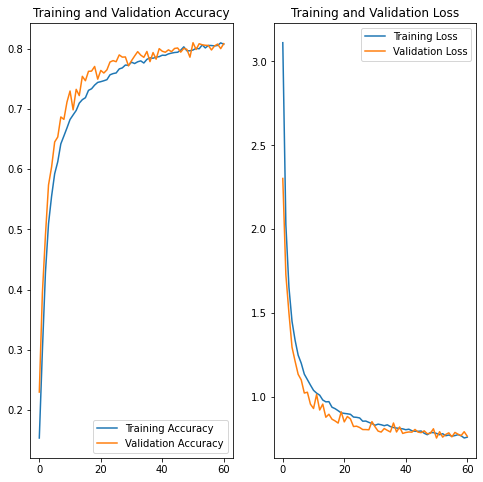

In [ ]:
show_accuracy(result17)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


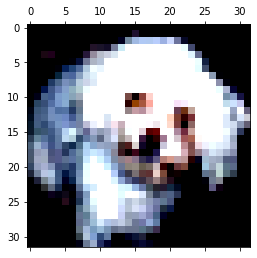

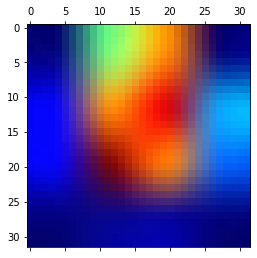

In [ ]:
last_conv_layer_name = 'conv2d_8'

img = x_test[1000]
plt.matshow(img)
img = img.reshape(-1, 32, 32, 3)
src_img = img.reshape(32, 32, 3)
heatmap = make_gradcam_heatmap(img, model17, last_conv_layer_name)
CAM = save_and_display_gradcam(src_img, heatmap, alpha=0.4)
plt.matshow(CAM)

**# 18 16번 모델에 GAP(Global Average Pooling) 추가**

In [10]:
dropout = 0.5
epochs = 100

model18 = keras.Sequential([
    
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=input_shape),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    
    layers.Conv2D(1024, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),

    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes,activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result18 = model18.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[callback]
)
model18.summary()

Epoch 1/100
98/98 [==============================] - 12s 111ms/step - loss: 2.2796 - accuracy: 0.3356 - val_loss: 1.7165 - val_accuracy: 0.4603
Epoch 2/100
98/98 [==============================] - 11s 109ms/step - loss: 1.6086 - accuracy: 0.4844 - val_loss: 1.4341 - val_accuracy: 0.5434
Epoch 3/100
98/98 [==============================] - 11s 110ms/step - loss: 1.3883 - accuracy: 0.5634 - val_loss: 1.2826 - val_accuracy: 0.6014
Epoch 4/100
98/98 [==============================] - 11s 110ms/step - loss: 1.2800 - accuracy: 0.6107 - val_loss: 1.2094 - val_accuracy: 0.6345
Epoch 5/100
98/98 [==============================] - 11s 110ms/step - loss: 1.1935 - accuracy: 0.6449 - val_loss: 1.1150 - val_accuracy: 0.6740
Epoch 6/100
98/98 [==============================] - 11s 111ms/step - loss: 1.1474 - accuracy: 0.6632 - val_loss: 1.0906 - val_accuracy: 0.6866
Epoch 7/100
98/98 [==============================] - 11s 111ms/step - loss: 1.1074 - accuracy: 0.6852 - val_loss: 1.0448 - val_accuracy:

In [13]:
test_loss, test_acc = model18.evaluate(x_test,  y_test, verbose=2)
print(test_loss), print(test_acc)

313/313 - 2s - loss: 0.8125 - accuracy: 0.8244
0.812518835067749
0.824400007724762


(None, None)

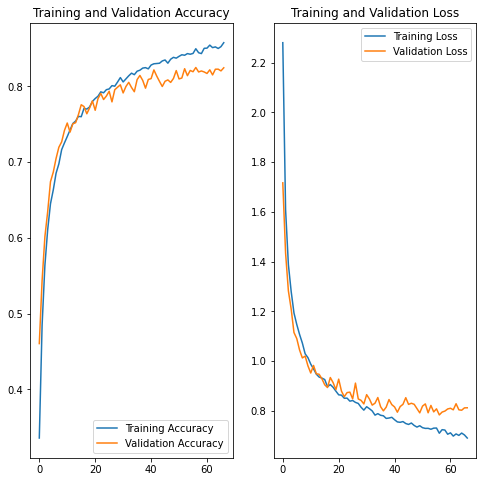

In [14]:
show_accuracy(result18)